# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
- opens all CMIP6 historical model run files with data on surface temperature tas
- opens ERSST observational dataset with sst sea surface temperature 
- calculates the Nino3.4 index for the data to test the ENSO state in the months before and after Krakatoa 1883


In [1]:
!ls '/home/563/kb6999/Functions'

frequently_used_functions.py  plotting_functions.py  reanalysis_functions.py
model_functions.py	      __pycache__


In [2]:
import xarray as xr, matplotlib.pyplot as plt
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

## Import and define custom functions

In [3]:
# import custom functions
import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [4]:
# find the ENSO events
def find_ENSO(nino34_index, threshold):
    """ Use the NINO34 index to find ENSO events that exceed a user-specified threshold and last longer than 5 months.  Then classify each month as either El Nino (1), La Nina (-1) or neutral (NaN). Combine this data into a pandas dataframe with models as the rows and months as the columns.  
        
        Args:
        nino34_index (xarray): data set of the NINO34 index values
        threshold (float): magnitude of threshold to classify ENSO events 
    """
        
    import climtas, xarray as xr, pandas as pd
    
    # find the events that exceed the el nino threshold and last longer than 5 months, and also la nina events
    nino_events0 = climtas.event.find_events(nino34_index.ts >= threshold, min_duration=5)
    nina_events0 = climtas.event.find_events(nino34_index.ts <= -threshold, min_duration=5)
    
    # extend events so that each month the event lasted is recorded and stored in the array nino_events
    nino_events = climtas.event.extend_events(nino_events0)
    nina_events = climtas.event.extend_events(nina_events0)
    
    # get the coordinates of the events 
    coords_nino = climtas.event.event_coords(nino34_index, nino_events)
    coords_nina = climtas.event.event_coords(nino34_index, nina_events)
    
    # Mark the type of each event (ie el nino or la nina)
    coords_nino['value'] = 1
    coords_nina['value'] = -1
    
    # Join the nino and nina events together
    coords_all = pd.concat([coords_nino, coords_nina])
    coords_all = coords_all.set_index('time', drop=False)

    # Now group the index column into years, returning the first event in each month??
    grouped_all = coords_all.groupby('model').resample('M').first()

    # Drop empty years
    grouped_all = grouped_all.dropna()

    # The text for the combined result, use pivot to put the models as rows and time as columns 
    result = grouped_all.pivot('model','time','value')
    
    # convert nan values to 0 so they're a number that I can use in my colours array
    # result = result.replace(np.nan, 0)
    
    return result 

In [54]:
# find models that recorded El Nino in DJF 1884 or DJF 1885 
def ENSO_sel(events_dataset, dec, jan, feb):
    """ Find and print and save to netcdf the number and names of models that recorded an El Nino (and then La Nina and neutral event) in at least 2 out of 3 of the DJF months in the years specified.  
        
        Args:
        events_dataset (dataframe): pandas dataframe of ENSO events (as returned by the find_ENSO function)
        dec (date_str): date of first summer month (December, year 1)
        jan (date_str): date of second summer month (January, following year)
        feb (date_str): date of third summer month (February, following year) 
    """
    import xarray as xr
    
    ds = []
    names = []
    ds2 = []
    names2 = []

    # convert to xarry so I can index the models
    dataset_xr = events_dataset.to_xarray()
    
    # remove the obs 
    dataset_xr = dataset_xr.drop_sel(model=[' ERSST Observations'])

    # find models that exceed el nino threshold (and last for longer than 5 months) in D, J and F 
    for m, model in enumerate(dataset_xr.model):   
        if ((events_dataset[f'{dec}'][model.data] + 
            events_dataset[f'{jan}'][model.data] + 
            events_dataset[f'{feb}'][model.data]) >= 2):
            ds.append(model)
            names.append(model.data)

    # store resulting model names in an xarray
    nino_models = xr.concat(ds, dim='model', coords = 'minimal')
    nino_models.coords['model'] = names

    #print resulting models
    print(len(nino_models), 'models record an El Nino in ', f'{dec}','-',f'{feb}'':')
    print(nino_models.model.data)
    
    # save nino models to_netcdf
    nino_models.model.to_netcdf('/home/563/kb6999/Models/ENSO_models/nino_' + f'{dec}' + '-' + f'{feb}' + '.nc')

    # find models that exceed la nina threshold (and last for longer than 5 months) in D, J and F 
    for m, model in enumerate(dataset_xr.model):   
        if ((events_dataset[f'{dec}'][model.data] +
            events_dataset[f'{jan}'][model.data] +
            events_dataset[f'{feb}'][model.data]) <= -2):
            ds2.append(model)
            names2.append(model.data)

    # store resulting model names in an xarray
    nina_models = xr.concat(ds2, dim='model', coords = 'minimal')
    nina_models.coords['model'] = names2

    #print resulting models
    print(len(nina_models), 'models record a La Nina in ', f'{dec}','-',f'{feb}'':')
    print(nina_models.model.data)
    
    # save nina models to_netcdf
    nina_models.model.to_netcdf('/home/563/kb6999/Models/ENSO_models/nina_' + f'{dec}' + '-' + f'{feb}' + '.nc')
    
    # drop models that have el nino or la nina (i.e. select out neutral models)
    neut_models = dataset_xr.model.where(~dataset_xr.model.isin(nino_models.model), drop = True)
    neut_models = neut_models.model.where(~neut_models.model.isin(nina_models.model), drop = True)
    
    #print resulting models
    print(len(neut_models), 'models record a neutral event in ', f'{dec}','-',f'{feb}'':')
    print(neut_models.model.data)
                                
    # save neut models to_netcdf
    #neut_models.model.to_netcdf('/home/563/kb6999/Models/ENSO_models/neut_' + f'{dec}' + '-' + f'{feb}' + '.nc')
    
    return 


In [6]:

# make a table for nino3.4 index, showing models in rows and months in columns (blue indicates el nino, red la nina)
def nino34_table(dataset, y0_header, y1_header, y0, y1, ax=None):
    """Create a colour-coded table showing ENSO events over time for each model. 
    Blue indicates el nino, red la nina, white neutral.  
    Models as rows and months as columns.    
    Return the axis.  
    
    Args:
        dataset (dataframe): pandas dataframe table of values (output of function "ENSO_models")
        y0_header (float): value determines the extent of the header
        y1_header (float): value determines the extent of the header
        y0 (float): value determines the extent of the table
        y1 (float): value determines the extent of the table
        colour_ar (dict): dictionary of colour strings 
        ax (axis): axis
    """
    import matplotlib.pyplot as plt, numpy as np, pandas as pd
    
    if ax is None:
        ax = plt.gca() 
    ax.axis('off')
    
    # convert nan values to 0 so they're a number that I can use in my colours array
    dataset = dataset.replace(np.nan, 0)
    
    # convert data to the right format so it can be used in my table 
    ds = dataset.to_xarray()
    ds2 = ds.to_array()
    ds2 = ds2.values
    # swap the axes so the models are in the columns 
    ds2 = np.swapaxes(ds2,0,1)
    
    # convert data to integers so I can use it to index my colour array
    ds2 = ds2.astype(int)
    
    # define an array of colours to be used (red el nion, blue la nina, white neutral)
    colour_ar = np.array(['white', 'crimson', 'royalblue'])

    # Use the data values as indices into the colour name array
    colours = colour_ar[ds2]
    
    # set column labels to each month
    cols = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    cols = cols*6
    
    # set row labels as the model names
    rows = ds.model.data
    
    # define array for column headers
    years = ['1882', '1883', '1884', '1885', '1886', '1887']

    # bbox has x0, x1, y0, y1 so determines the size (and location??) of the table
    # make header first (bbox=[x0=0, y0=0.67, x1=1, y1=0.06)
    header_0 = ax.table(cellText=[['']*len(years)], colLabels=years, loc='bottom', bbox=[0, y0_header, 1, y1_header])
    # then make table below (bbox=[x0=0, y0=-0.3, x1=1, y1=1)
    the_table = ax.table(cellColours= colours, rowLabels=rows, colLabels=cols, loc='bottom',cellLoc='center', bbox=[0, y0, 1, y1])
    
    return ax 


In [7]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [8]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5/

v20200302


In [9]:
!ls /g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc

/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc


In [10]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [11]:
models_tas = funcM.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [12]:
models_pr = funcM.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [13]:
models_ts = funcM.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [14]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [15]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [16]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Read in obs data

In [17]:
# read in obs data from ersst dataset 
ersst_path = '/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc'
ersst = xr.open_dataset(ersst_path)
if 'time_bnds' in ersst:
    del ersst['time_bnds']
ersst

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 240, time: 1989)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-09-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    history:                   Thu Dec 03 18:13:58 2020: cdo remapcon,r240x12...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    Conventions:               CF-1.6, ACDD-1.3
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0
    geospatial_laty_max:       89.0
    geospatial_laty_min:       -89.0
    geospatial_lat_max:        89.0
    geospatial_lat_min:        -89.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    cdm_data_type:             Grid
    project:                   NOAA Extended Reconstructed Sea Surface Temper...
    original_publisher_url:    http://www.ncdc.noaa.gov
    References:                https://www.ncdc.noaa.gov/data-access/marineoc...
    title:                     NOAA ERSSTv5 (in situ only)
    citation:                  Huang et al, 2017: Extended Reconstructed Sea ...
    platform:                  Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    standard_name_vocabulary:  CF Standard Name Table (v40, 25 January 2017)
    processing_level:          NOAA Level 4
    metadata_link:             :metadata_link = https://doi.org/10.7289/V5T72...
    creator_name:              Boyin Huang (original)
    date_created:              2017-06-30T12:18:00Z (original)
    product_version:           Version 5
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2019-10-03
    CDO:                       Climate Data Operators version 1.9.8 (https://...

In [18]:
# convert to month end frequency (rahter than month start)
ersst = ersst.resample(time = 'M').mean()

## Area weighting
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [19]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

In [20]:
ersst_w = ersst*np.cos(ersst.lat*(np.pi/180))

## Nino 3.4

In [21]:
# add the multi-model mean to the data-array
# models_w_mmm = func.add_mmm(models_w)

# calculate the multi-model mean
mmm = models_w.mean(dim='model')

In [22]:
# calculate the nino3.4 index for all models for every month divided by std
nino34_index = func.nino34(models_w, '1850-01', '1880-01', 1)

In [23]:
# calculate the nino3.4 index for multi-model mean for every month divided by std
nino34_mmm = func.nino34(mmm, '1850-01', '1880-01', 1)

In [24]:
func=reload(func)

In [25]:
# calculate the nino3.4 index for obs data for every month
nino34_obs = func.nino34(ersst_w, '1850-01', '1880-01', 0)

### Threshold

In [26]:
# set the threshold for el nino/la nia events
THOLD = 0.4

# Graphs

In [27]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

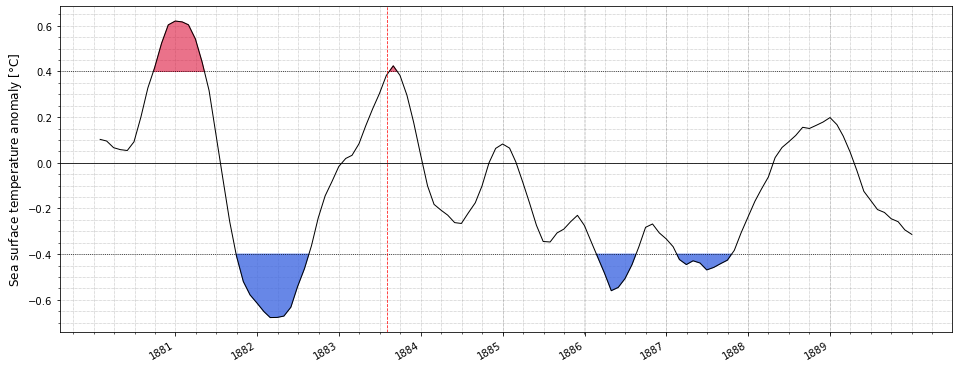

In [28]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

fplot.nino34_plot(nino34_mmm.ts.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

plt.savefig('nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

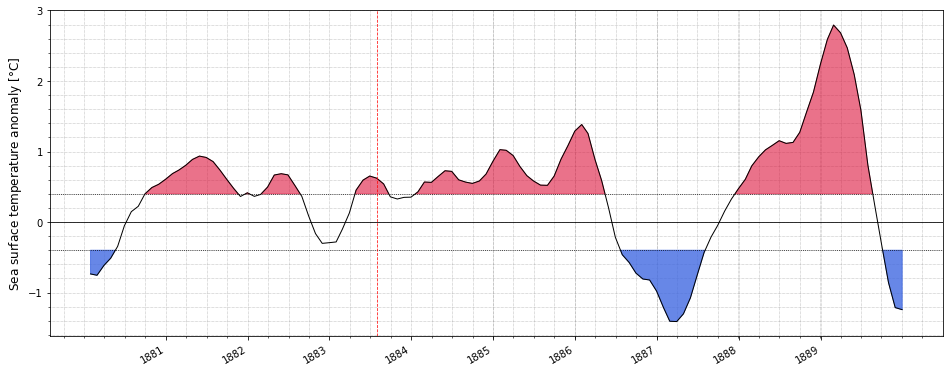

In [29]:
# plot time series of nino3.4 index for the obs ERSST dataset 
fig, axes = plt.subplots(figsize=(16,6))

fplot.nino34_plot(nino34_obs.sst.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

plt.savefig('nino34_plot_obs.png', dpi=300, bbox_inches='tight')

## next i want to classify each year as either el nino, la nina or neutral and then plot the results in a table 
to do this i need to count the number of el nino/la nina/ neutral events each year 
record count of dominant event for the year
then write the count and colour code (red el nino, blue la nina, white/grey neutral)  

In [30]:
# select out the years near the eruption
nino34_obs = nino34_obs.sel(time=slice('1882-01','1887-12'))
nino34_index = nino34_index.sel(time=slice('1882-01','1887-12'))

In [31]:
# add model dimension to obs dataset
ds = []
ds.append(nino34_obs)
obs = xr.concat(ds, dim='model', coords = 'minimal')
obs.coords['model'] = [' ERSST Observations']
# rename sst variable to ts so we can concat the datasets
obs = obs.rename_vars({'sst': 'ts'})

In [32]:
# append the obs to the rest of the anomaly array
ds2=[]
ds2.append(nino34_index)
ds2.append(obs)
nino34_index = xr.concat(ds2, dim='model', coords = 'minimal', compat='override')

# Produce a table showing onset date of el nino events (anomalies above threshold that last longer than 5 months) 

In [33]:
# find the nino/nina events over the specified threshold and lasting longer than 5 months
ENSO_events_04 = find_ENSO(nino34_index, 0.4)

In [55]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1882
dec82 = '1882-12-31' ; jan83 = '1883-01-31';  feb83 = '1883-02-28'
ENSO_sel(ENSO_events_04, dec82, jan83, feb83)

14 models record an El Nino in  1882-12-31 - 1883-02-28:
['ACCESS-CM2' 'ACCESS-ESM1-5' 'BCC-CSM2-MR' 'CAMS-CSM1-0' 'CESM2-FV2'
 'CESM2-WACCM' 'CanESM5' 'E3SM-1-1' 'FGOALS-f3-L' 'FGOALS-g3'
 'GISS-E2-1-G-CC' 'KACE-1-0-G' 'MIROC6' 'SAM0-UNICON']
12 models record a La Nina in  1882-12-31 - 1883-02-28:
['BCC-ESM1' 'CAS-ESM2-0' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'EC-Earth3-AerChem'
 'FIO-ESM-2-0' 'GFDL-CM4' 'GISS-E2-1-G' 'IPSL-CM6A-LR' 'MPI-ESM-1-2-HAM'
 'NESM3' 'NorESM2-MM']
16 models record a neutral event in  1882-12-31 - 1883-02-28:
['AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR' 'CESM2' 'CESM2-WACCM-FV2' 'E3SM-1-1-ECA'
 'EC-Earth3' 'EC-Earth3-Veg-LR' 'GFDL-ESM4' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM5-0' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NorCPM1' 'NorESM2-LM' 'TaiESM1']


In [56]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1883
dec83 = '1883-12-31' ; jan84 = '1884-01-31';  feb84 = '1884-02-29'
ENSO_sel(ENSO_events_04, dec83, jan84, feb84)

10 models record an El Nino in  1883-12-31 - 1884-02-29:
['BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2-FV2' 'E3SM-1-1' 'EC-Earth3'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'GFDL-ESM4' 'IITM-ESM']
12 models record a La Nina in  1883-12-31 - 1884-02-29:
['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-ESM-1-1-LR' 'CMCC-CM2-SR5'
 'EC-Earth3-AerChem' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'KACE-1-0-G'
 'MRI-ESM2-0' 'NESM3' 'NorESM2-MM']
20 models record a neutral event in  1883-12-31 - 1884-02-29:
['AWI-CM-1-1-MR' 'BCC-CSM2-MR' 'CESM2' 'CESM2-WACCM' 'CESM2-WACCM-FV2'
 'CMCC-CM2-HR4' 'CanESM5' 'E3SM-1-1-ECA' 'GISS-E2-1-G' 'GISS-E2-1-G-CC'
 'GISS-E2-1-H' 'INM-CM5-0' 'IPSL-CM6A-LR' 'MIROC6' 'MPI-ESM-1-2-HAM'
 'MPI-ESM1-2-LR' 'NorCPM1' 'NorESM2-LM' 'SAM0-UNICON' 'TaiESM1']


In [57]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1884
dec84 = '1884-12-31' ; jan85 = '1885-01-31';  feb85 = '1885-02-28'
ENSO_sel(ENSO_events_04, dec84, jan85, feb85)

16 models record an El Nino in  1884-12-31 - 1885-02-28:
['CESM2' 'CESM2-WACCM' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'EC-Earth3'
 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'GISS-E2-1-G' 'GISS-E2-1-H'
 'IITM-ESM' 'KACE-1-0-G' 'NESM3' 'NorESM2-LM' 'SAM0-UNICON' 'TaiESM1']
12 models record a La Nina in  1884-12-31 - 1885-02-28:
['ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR' 'CAMS-CSM1-0'
 'CESM2-WACCM-FV2' 'E3SM-1-1-ECA' 'EC-Earth3-Veg-LR' 'FGOALS-f3-L'
 'GFDL-ESM4' 'GISS-E2-1-G-CC' 'MPI-ESM1-2-LR' 'NorESM2-MM']
14 models record a neutral event in  1884-12-31 - 1885-02-28:
['ACCESS-CM2' 'BCC-CSM2-MR' 'BCC-ESM1' 'CAS-ESM2-0' 'CESM2-FV2' 'CanESM5'
 'E3SM-1-1' 'EC-Earth3-AerChem' 'INM-CM5-0' 'IPSL-CM6A-LR' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MRI-ESM2-0' 'NorCPM1']


In [58]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1885
dec85 = '1885-12-31' ; jan86 = '1886-01-31';  feb86 = '1886-02-28'
ENSO_sel(ENSO_events_04, dec85, jan86, feb86)

5 models record an El Nino in  1885-12-31 - 1886-02-28:
['ACCESS-ESM1-5' 'CAS-ESM2-0' 'CESM2-WACCM-FV2' 'CMCC-CM2-SR5'
 'GISS-E2-1-G']
13 models record a La Nina in  1885-12-31 - 1886-02-28:
['CESM2' 'CMCC-CM2-HR4' 'E3SM-1-1' 'EC-Earth3-Veg-LR' 'FIO-ESM-2-0'
 'GFDL-CM4' 'GFDL-ESM4' 'IITM-ESM' 'KACE-1-0-G' 'MPI-ESM-1-2-HAM'
 'MPI-ESM1-2-LR' 'NorCPM1' 'TaiESM1']
24 models record a neutral event in  1885-12-31 - 1886-02-28:
['ACCESS-CM2' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR' 'BCC-CSM2-MR' 'BCC-ESM1'
 'CAMS-CSM1-0' 'CESM2-FV2' 'CESM2-WACCM' 'CanESM5' 'E3SM-1-1-ECA'
 'EC-Earth3' 'EC-Earth3-AerChem' 'FGOALS-f3-L' 'FGOALS-g3'
 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'INM-CM5-0' 'IPSL-CM6A-LR' 'MIROC6'
 'MRI-ESM2-0' 'NESM3' 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON']


In [59]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1886
dec86 = '1886-12-31' ; jan87 = '1887-01-31';  feb87 = '1887-02-28'
ENSO_sel(ENSO_events_04, dec86, jan87, feb87)

8 models record an El Nino in  1886-12-31 - 1887-02-28:
['ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'CAMS-CSM1-0' 'CESM2-WACCM'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'NorESM2-MM' 'SAM0-UNICON']
15 models record a La Nina in  1886-12-31 - 1887-02-28:
['ACCESS-CM2' 'BCC-CSM2-MR' 'BCC-ESM1' 'CAS-ESM2-0' 'CESM2'
 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CanESM5' 'EC-Earth3' 'GFDL-ESM4'
 'GISS-E2-1-H' 'IITM-ESM' 'MRI-ESM2-0' 'NorCPM1' 'TaiESM1']
19 models record a neutral event in  1886-12-31 - 1887-02-28:
['AWI-ESM-1-1-LR' 'CESM2-FV2' 'CMCC-CM2-SR5' 'E3SM-1-1' 'E3SM-1-1-ECA'
 'EC-Earth3-AerChem' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'GISS-E2-1-G'
 'GISS-E2-1-G-CC' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'NESM3' 'NorESM2-LM']


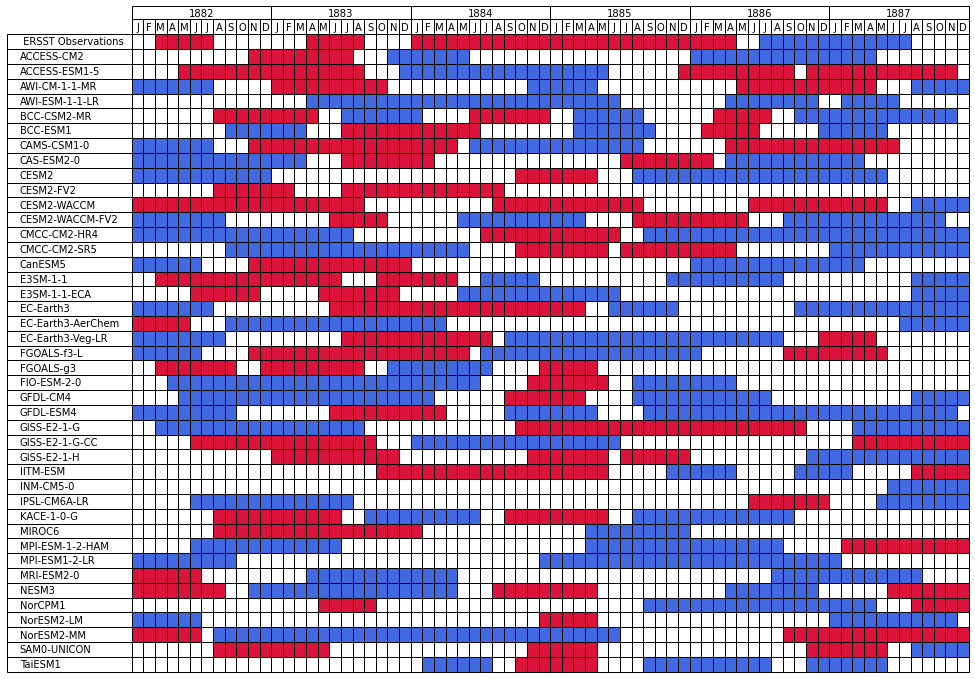

In [54]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,8))

# set the bbox (figure height and width)
y0_h = 0.97 # sets the start/base of the header height
y1_h = 0.06 # sets the header height
y0 = -0.5 # sets the base of main table height??
y1 = 1.5 # sets the main table height (and therefore height of each cell)
# call function to make the table
nino34_table(ENSO_events_04, y0_h, y1_h, y0, y1)

# save table as pdf 
plt.savefig('nino3.4_table_0.4thold.pdf', dpi=300, bbox_inches='tight')